# Model 3

### Target:

- Add Batch-norm to increase model efficiency.

### Results:

- Parameters : 7,448
- Best Train Accuracy : 99.51
- Best Test Accuracy : 99.30

### Analysis:

- We have started to see over-fitting now. 
- Even if the model is pushed further, it won't be able to get to 99.30

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_mnist_data

In [4]:
train , test = load_mnist_data(train_transforms,test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\Tharun\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


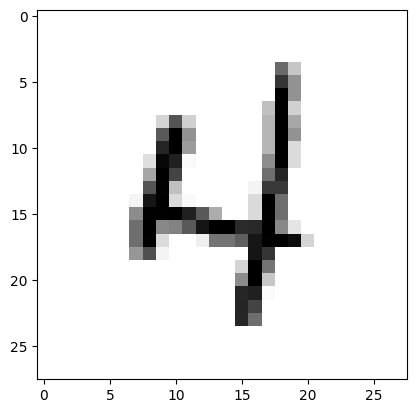

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [7]:
from utils import plot_images

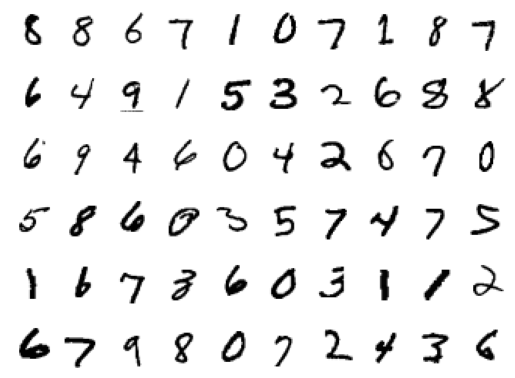

In [8]:
plot_images(images)

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [9]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The Model

Let's continue with the skeleton model (model-2) adding Batch-Normalisation to it.

In [10]:
from model import Model3 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
       BatchNorm2d-8            [-1, 8, 24, 24]              16
              ReLU-9            [-1, 8, 24, 24]               0
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
           Conv2d-14              

# Training and Testing

All right, so we have 7,448 params. The purpose of this notebook is to change the skeleton structure of our model adding Batch-Normalization.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's import train and test functions from our `model.py` script file

In [12]:
from model import train,test

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch , train_losses , train_acc)
    test(model, device, test_loader ,test_losses , test_acc)

EPOCH: 0


Loss=0.07166680693626404 Batch_id=468 Accuracy=88.77: 100%|██████████████████████████| 469/469 [00:08<00:00, 52.29it/s]



Test set: Average loss: 0.1041, Accuracy: 9743/10000 (97.43%)

EPOCH: 1


Loss=0.1292790025472641 Batch_id=468 Accuracy=98.23: 100%|███████████████████████████| 469/469 [00:08<00:00, 57.89it/s]



Test set: Average loss: 0.0500, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.02888166718184948 Batch_id=468 Accuracy=98.56: 100%|██████████████████████████| 469/469 [00:08<00:00, 58.10it/s]



Test set: Average loss: 0.0370, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.014175568707287312 Batch_id=468 Accuracy=98.78: 100%|█████████████████████████| 469/469 [00:07<00:00, 58.84it/s]



Test set: Average loss: 0.0392, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.020808083936572075 Batch_id=468 Accuracy=98.95: 100%|█████████████████████████| 469/469 [00:08<00:00, 57.52it/s]



Test set: Average loss: 0.0316, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.019815577194094658 Batch_id=468 Accuracy=99.03: 100%|█████████████████████████| 469/469 [00:08<00:00, 58.00it/s]



Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.0400361530482769 Batch_id=468 Accuracy=99.12: 100%|███████████████████████████| 469/469 [00:08<00:00, 58.43it/s]



Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.028728244826197624 Batch_id=468 Accuracy=99.17: 100%|█████████████████████████| 469/469 [00:08<00:00, 58.22it/s]



Test set: Average loss: 0.0284, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.03308876231312752 Batch_id=468 Accuracy=99.24: 100%|██████████████████████████| 469/469 [00:08<00:00, 57.74it/s]



Test set: Average loss: 0.0342, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.07383350282907486 Batch_id=468 Accuracy=99.26: 100%|██████████████████████████| 469/469 [00:08<00:00, 58.50it/s]



Test set: Average loss: 0.0316, Accuracy: 9898/10000 (98.98%)

EPOCH: 10


Loss=0.006574240047484636 Batch_id=468 Accuracy=99.33: 100%|█████████████████████████| 469/469 [00:07<00:00, 58.82it/s]



Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.05341478809714317 Batch_id=468 Accuracy=99.37: 100%|██████████████████████████| 469/469 [00:07<00:00, 58.65it/s]



Test set: Average loss: 0.0295, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.003186098299920559 Batch_id=468 Accuracy=99.40: 100%|█████████████████████████| 469/469 [00:08<00:00, 58.30it/s]



Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.04717683792114258 Batch_id=468 Accuracy=99.48: 100%|██████████████████████████| 469/469 [00:08<00:00, 58.54it/s]



Test set: Average loss: 0.0244, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.04686102271080017 Batch_id=468 Accuracy=99.51: 100%|██████████████████████████| 469/469 [00:08<00:00, 57.96it/s]



Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)



In [14]:
from model import plot_graphs

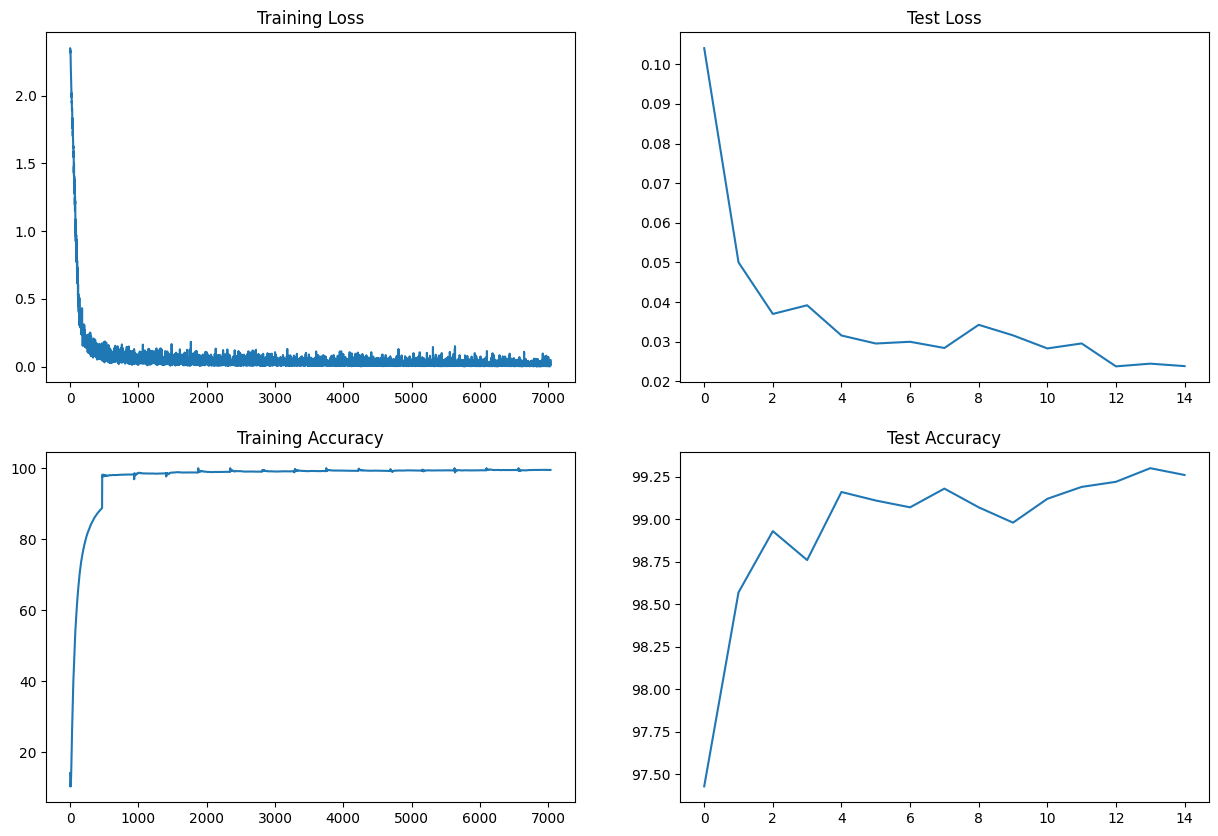

In [15]:
plot_graphs(train_losses , train_acc , test_losses , test_acc)